
<img alt='UCL' src="images/ucl_logo.png" align='center'>


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](050_Models.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](042_Weighted_smoothing_and_interpolation.ipynb)



# 043 Weighted interpolation

##  Introduction

### Purpose

We have seen in [042_Weighted_smoothing_and_interpolation](042_Weighted_smoothing_and_interpolation.ipynb) how we can regularise a dataset using colvolution filtering. We investigate and apply that now to allow us to provide gap-filled datasets.

### Prerequisites

You must make sure you can recall the details of the work covered in [040_GDAL_mosaicing_and_masking](040_GDAL_mosaicing_and_masking.ipynb) and understand the material in [042_Weighted_smoothing_and_interpolation](042_Weighted_smoothing_and_interpolation.ipynb). You will also need to know how to do [graph plotting](023_Plotting.ipynb), including sub-figures and errorbars, and [image display](024_Image_display.ipynb).

### Test

You should run a [NASA account test](004_Accounts.ipynb) if you have not already done so.

## Smoothing

In convolution, we combine a *signal* $y$ with a *filter* $f$ to achieve a filtered signal. For example, if we have an noisy signal, we will attempt to reduce the influence of high frequency information in the signal (a 'low pass' filter, as we let the low frequency information *pass*).

We can perform a weighted interpolation by:

* numerator   = smooth( signal $\times$ weight)
* denominator = smooth( weight)
* result = numerator/denominator

We will now load up a dataset (LAI for LU for 2019) to explore smoothing. We will use the function [get_lai_data](geog0111/get_lai_data.py) that we have previously developed:

In [1]:
from geog0111.get_lai_data import get_lai_data
import numpy as np

# load some data
tile    = ['h17v03','h18v03','h17v04','h18v04']
year    = 2019
fips    = "LU"

lai,std,doy =  get_lai_data(year,tile,fips)

# sort the weight as in the exercio
std[std<1] = 1
weight = np.zeros_like(std)
mask = (std > 0)
weight[mask] = 1./(std[mask]**2)
weight[lai > 10] = 0.

#### Exercise 1

* Write a function `get_weight` that takes as argument:
    
        lai  : MODIS LAI dataset
        std  : MODIS LAI uncertainty dataset 
        
  and returns an array the same shape as lai/std of per-pixel pixel weights
* Read a MODIS LAI dataset, calculate the weights, and print some statistics of the weights


In [2]:
# ANSWER
'''
a function `get_weight` that takes as argument:

lai  : MODIS LAI dataset
std  : MODIS LAI uncertainty dataset 
'''
def get_weight(lai,std):
    std[std<1] = 1
    weight = np.zeros_like(std)
    mask = (std > 0)
    weight[mask] = 1./(std[mask]**2)
    weight[lai > 10] = 0.

    return weight

In [3]:
# ANSWER

from geog0111.get_lai_data import get_lai_data
# load some data
tile    = ['h17v03','h18v03','h17v04','h18v04']
year    = 2019
fips    = "LU"
lai,std,doy =  get_lai_data(year,tile,fips)

weight = get_weight(lai,std)
print(f'weight min:    {weight.min()}')
print(f'weight max:    {weight.max()}')
print(f'weight mean:   {weight.mean()}')
print(f'weight median: {np.median(weight)}')
print(f'weight sum:    {weight.sum()}')

weight min:    0.0
weight max:    1.0
weight mean:   0.3184627847952631
weight median: 0.0016259105098855356
weight sum:    625524.6018948557


We can plot the dataset for a given pixel (`(107,72)` here) to see some of the features of the data:

0.0 1.0 1 365


Text(0, 0.5, 'LAI')

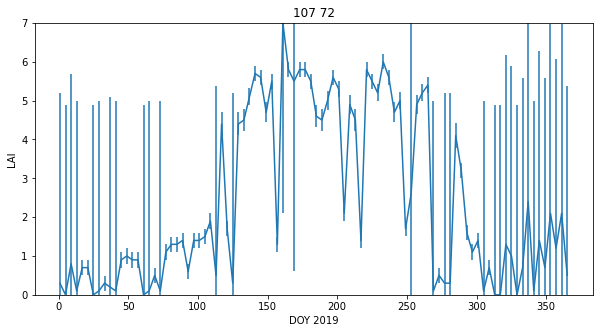

In [4]:
import matplotlib.pyplot as plt

# look at some stats
print(weight.min(),weight.max(),doy.min(),doy.max())
error = np.zeros_like(weight)
error[weight>0] = np.sqrt(1./(weight[weight>0] )) * 1.97

p0,p1 = (107,72)
x_size,y_size=(10,5)

shape=(10,10)
fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy

axs.errorbar(x,lai[:,p0,p1],yerr=error[:,p0,p1]/10)
axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')

The LAI data, that we expect to be smoothly varying in time, has unrealistic high frequency variations (it goes up and down too much). It also has data missing for some days (e.g. when too cloudy), and is often, in the winter, highly uncertain.

Despite that, we can 'see' that there should be a smoothly varying function that can go through those data points quite well. This is what we want to achieve with our regularisation.

### Smoothing

We can generate a Gaussian filter for our smoothing. The width of the filter, that in turn controls the degree of smoothing, is set by the parameter `sigma`. Recall the impact of the filter width from the [material in the previous session](042_Weighted_smoothing_and_interpolation.ipynb#Filter-width-and-degree-of-smoothing). We will use a value of `5` here, but you should *not* assume that that will always be appropriate. We will discuss how to experiment with this later in this session.

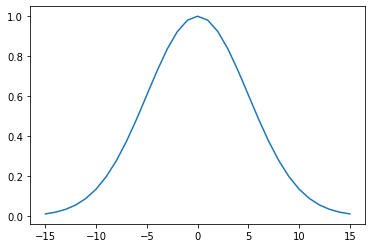

In [5]:
import scipy
import scipy.ndimage.filters

# sigma controls the width of the smoother
sigma = 5

x = np.arange(-3*sigma,3*sigma+1)
gaussian = np.exp((-(x/sigma)**2)/2.0)

plt.plot(x,gaussian)

We now perform the weighted regularisation by convolution.

In [6]:
numerator = scipy.ndimage.filters.convolve1d(lai * weight, gaussian, axis=0,mode='wrap')
denominator = scipy.ndimage.filters.convolve1d(weight, gaussian, axis=0,mode='wrap')

# avoid divide by 0 problems by setting zero values
# of the denominator to not a number (NaN)
denominator[denominator==0] = np.nan

interpolated_lai = numerator/denominator

We can plot the results in various ways:

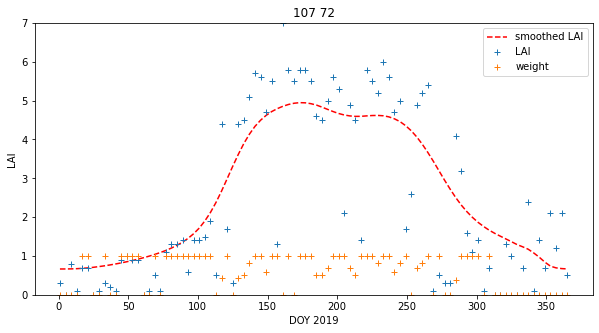

In [7]:
p0,p1 = (107,72)
x_size,y_size=(10,5)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,interpolated_lai[:,p0,p1],'r--',label='smoothed LAI')
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')
axs.legend(loc='best')

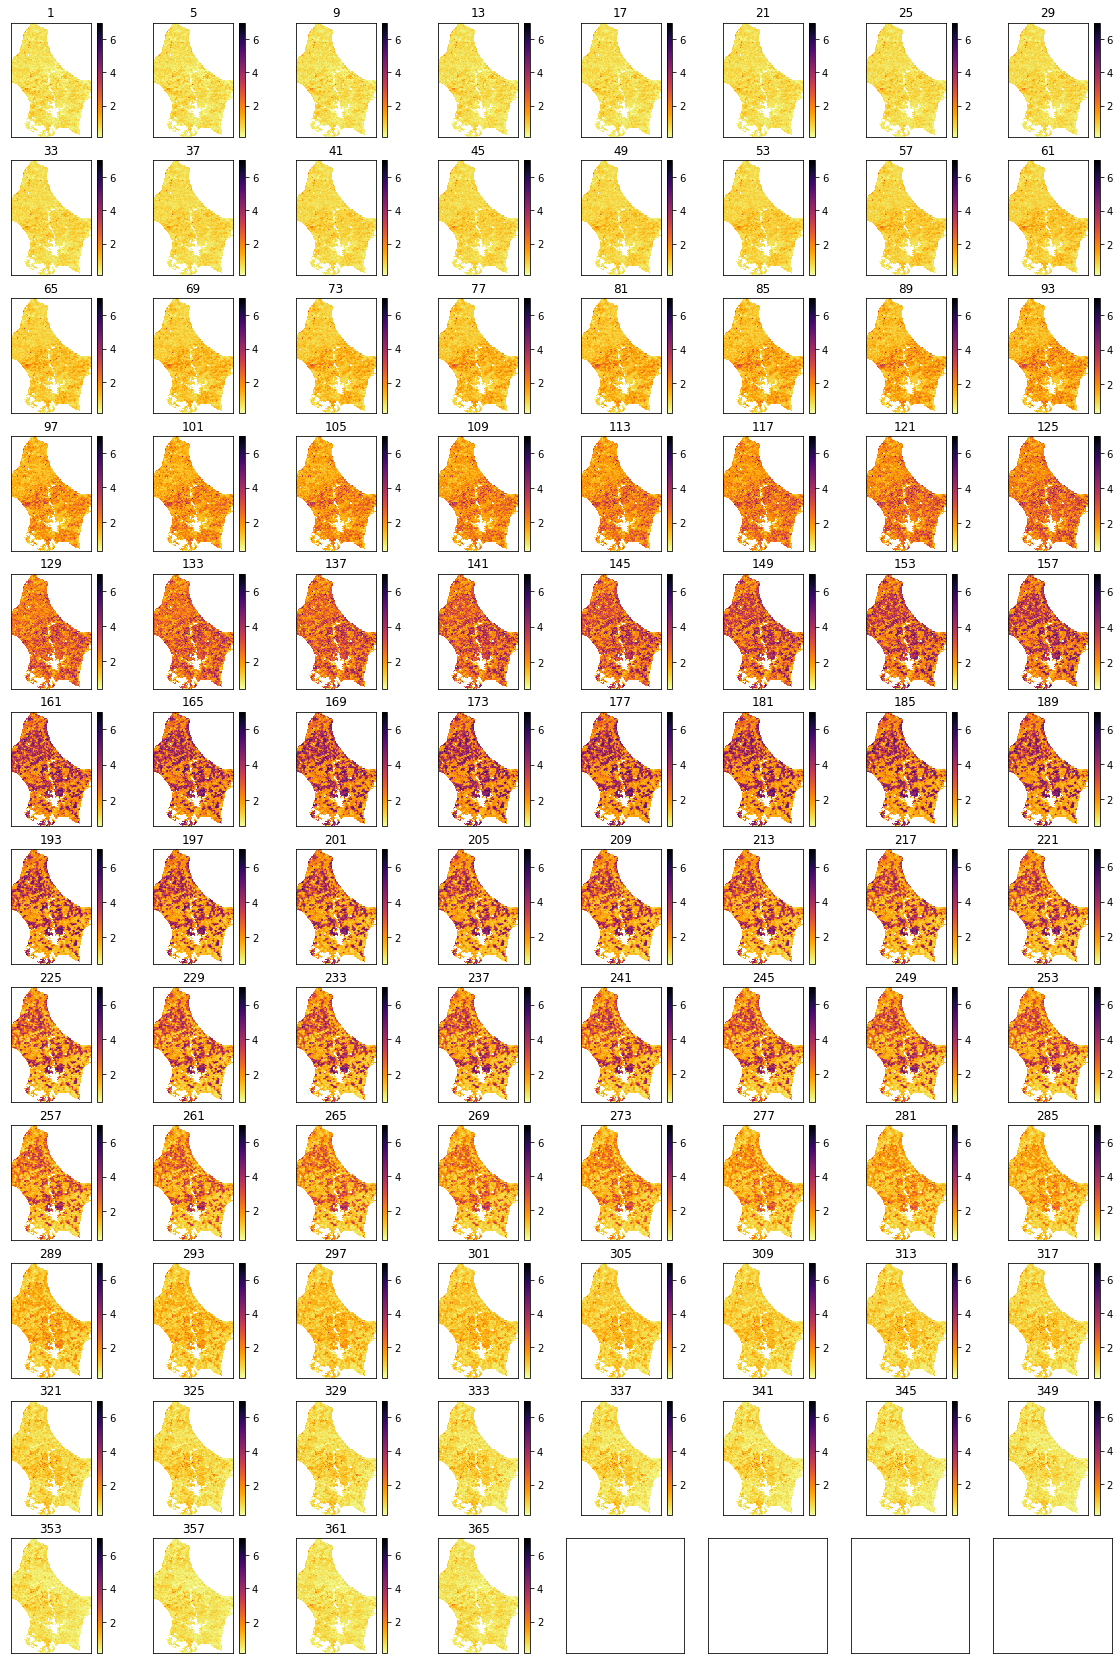

In [8]:
# Plot the interpolated_lai
import matplotlib.pyplot as plt

shape=(12,8)
x_size,y_size=(20,30)

fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
axs = axs.flatten()
plt.setp(axs, xticks=[], yticks=[])

for i in range(interpolated_lai.shape[0]):
    im = axs[i].imshow(interpolated_lai[i],vmax=7,cmap=plt.cm.inferno_r,\
                       interpolation='nearest')
    axs[i].set_title(doy[i])
    fig.colorbar(im, ax=axs[i])

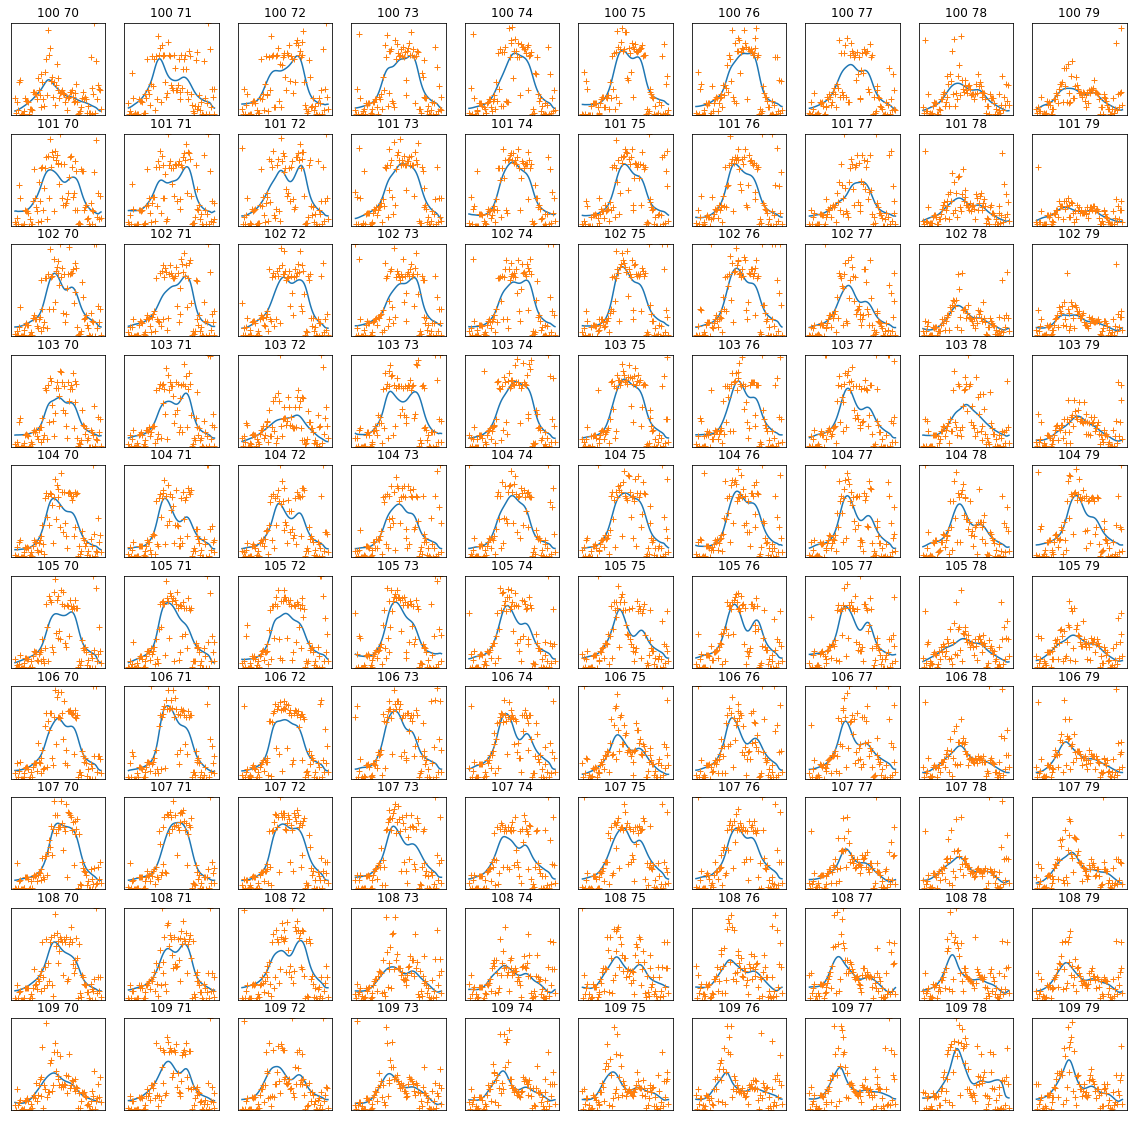

In [9]:
import matplotlib.pyplot as plt

x_size,y_size=(20,20)

shape=(10,10)
fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
plt.setp(axs, xticks=[], yticks=[])

pixel = (100,70)
x = doy

for i in range(shape[0]):
    p0 = pixel[0] + i
    for j in range(shape[1]):
        p1 = pixel[1] + j
        axs[i,j].plot(x,interpolated_lai[:,p0,p1])
        axs[i,j].plot(x,lai[:,p0,p1],'+')
        axs[i,j].set_title(f'{p0} {p1}')
        # ensure the same scale for all
        axs[i,j].set_ylim(0,7)

This achieves very plausible results for this dataset. The time series plots are particularly useful in judging this: we see that the smoothed signal describes the cloud of observations well. Further, there are no gaps in the data. A visual assessment of this kind is a useful tool for deciding if we are on the right track with our regularisation. We have not justified the filter width value we have used though.

#### Exercise 2

* Write a function `regularise` that takes as argument:
    
        lai     : MODIS LAI dataset
        weight  : MODIS LAI weight
        sigma   : Gaussian filter width
        
  and returns an array the same shape as lai of regularised LAI
* Read a MODIS LAI dataset and regularise it
* Plot original LAI, and regularised LAI for varying values of sigma, for one pixel

Hint: You will find such a function useful when completing Part B of the assessed practical, so it is well worth your while doing this exercise.

In [10]:
# ANSWER
import numpy as np
import scipy
import scipy.ndimage.filters

# regularise
def regularise(lai,weight,sigma):
    '''
    takes as argument:
    
        lai     : MODIS LAI dataset:     shape (Nt,Nx,Ny)
        weight  : MODIS LAI weight:      shape (Nt,Nx,Ny)
        sigma   : Gaussian filter width: float
        
    returns an array the same shape as 
    lai of regularised LAI. Regularisation takes place along
    axis 0 (the time axis)
    '''
    x = np.arange(-3*sigma,3*sigma+1)
    gaussian = np.exp((-(x/sigma)**2)/2.0)

    numerator = scipy.ndimage.filters.convolve1d(lai * weight, gaussian, axis=0,mode='wrap')
    denominator = scipy.ndimage.filters.convolve1d(weight, gaussian, axis=0,mode='wrap')

    # avoid divide by 0 problems by setting zero values
    # of the denominator to not a number (NaN)
    denominator[denominator==0] = np.nan

    interpolated_lai = numerator/denominator
    # (Nt,Nx,Ny)
    return interpolated_lai


In [11]:
# Read a MODIS LAI dataset and regularise it
import numpy as np
from geog0111.get_lai_data import get_lai_data
from geog0111.get_weight import get_weight

# load some data
tile    = ['h17v03','h18v03','h17v04','h18v04']
year    = 2019
fips    = "LU"
sigma   = 5

lai,std,doy =  get_lai_data(year,tile,fips)

weight = get_weight(lai,std)

# make a dictionary
interpolated_lai = {}
for sigma in [2,5,10,20,30]:
    interpolated_lai[sigma] = regularise(lai,weight,sigma)

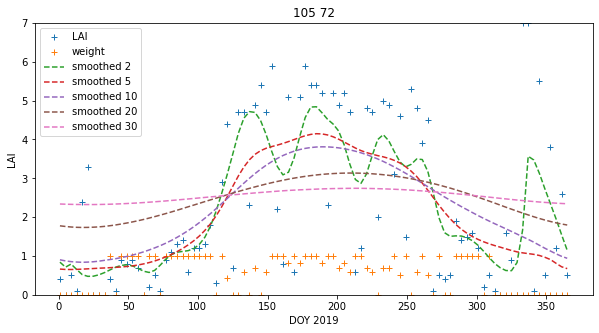

In [12]:
import matplotlib.pyplot as plt

p0,p1 = 105,72
x_size,y_size=(10,5)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')

for sigma in [2,5,10,20,30]:
    axs.plot(x,interpolated_lai[sigma][:,p0,p1],'--',label=f'smoothed {sigma}')


axs.legend(loc='best')

## data mask

Although these datasets look complete when we plot them, it is still possible that some pixels have no valid data points or invalid pixels. Earlier, we set 

        denominator[denominator==0] = np.nan

so we would expect invalid pixels to contain `np.nan`. We can build a mask for these pixels, for example by summing along the time axis (axis 0):

        mask = np.sum(interpolated_lai,axis=0)
        
This will build a 2D dataset that is `np.nan` if invalid. We can then use `~np.isnan` to build a boolean mask. The `~` symbol is the same as doing `np.logical_not()` in this context. It will be `True` where invalid, and `False` where valid:

In [13]:
# reload the dataset
from geog0111.get_lai_data import get_lai_data
from geog0111.get_weight import get_weight
from geog0111.regularise import regularise

lai,std,doy =  get_lai_data(year,tile,fips)
weight = get_weight(lai,std)
interpolated_lai = regularise(lai,weight,5.0)

Text(0.5, 1.0, 'data mask')

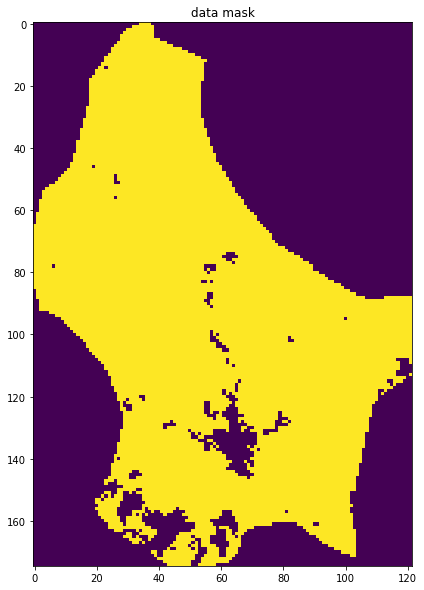

In [14]:
mask = ~np.isnan(np.sum(interpolated_lai,axis=0))

x_size,y_size=(10,10)
fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.imshow(mask)
axs.set_title('data mask')

## Land cover

We have generated a gap-filled LAI dataset, and have checked the quality of it. Lets now load some land cover data so that we can examine LAI as a function of land cover class:

We will use `LC_Type3` as this is the classification associated with the LAI product. You will find a CSV file defining the LC types in [`data/LC_Type3_colour.csv`](data/LC_Type3_colour.csv).


In [15]:
from geog0111.modis import Modis

# LU
kwargs = {
    'tile'      :    ['h17v03', 'h18v03','h17v04', 'h18v04'],
    'product'   :    'MCD12Q1',
}

year  = 2019
doy = 1
# get the data
modis = Modis(**kwargs)

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='LU'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

# specify day of year (DOY) and year
lcfiles = modis.get_modis(year,doy,warp_args=warp_args)
lcfiles.keys()

dict_keys(['LC_Prop1', 'LC_Prop1_Assessment', 'LC_Prop2', 'LC_Prop2_Assessment', 'LC_Prop3', 'LC_Prop3_Assessment', 'LC_Type1', 'LC_Type2', 'LC_Type3', 'LC_Type4', 'LC_Type5', 'LW', 'QC', 'bandnames'])

In [16]:
import pandas as pd
# read the colour data
lc_Type3 = pd.read_csv('data/LC_Type3_colour.csv')
lc_Type3

,code,colour,class,description
0,0,#1c0dff,Water Bodies,at least 60% of area is covered by permanent w...
1,1,#b6ff05,Grasslands,dominated by herbaceous annuals (<2m) includin...
2,2,#dcd159,Shrublands,shrub (1-2m) cover >10%.
3,3,#c24f44,Broadleaf,Croplands: bominated by herbaceous annuals (<2...
4,4,#fbff13,Savannas,between 10-60% tree cover (>2m).
5,5,#086a10,Evergreen Broadleaf Forests,dominated by evergreen broadleaf and palmate t...
6,6,#78d203,Deciduous Broadleaf Forests,dominated by deciduous broadleaf trees (canopy...
7,7,#05450a,Evergreen Needleleaf Forests,dominated by evergreen conifer trees (canopy >...
8,8,#54a708,Deciduous Needleleaf Forests,dominated by deciduous needleleaf (larch) tree...
9,9,#f9ffa4,Non-Vegetated Lands,at least 60% of area is non-vegetated barren (...


In [17]:
# generate matplotlib cmap and norm objects from these
# as in session 024
import matplotlib
import matplotlib.patches

cmap = matplotlib.colors.\
        ListedColormap(list(lc_Type3['colour']))
norm = matplotlib.colors.\
        BoundaryNorm(list(lc_Type3['code']), len(lc_Type3['code']))

# set up the legend
legend_labels = dict(zip(list(lc_Type3['colour']),list(lc_Type3['class'])))
patches = [matplotlib.patches.Patch(color=c, label=l)
           for c,l in legend_labels.items()]

In [18]:
import gdal
import numpy as np

# read the LC_Type3 dataset
g = gdal.Open(lcfiles['LC_Type3'])
land_cover = g.ReadAsArray()

# If the unique values dont correspond with
# what we expect for the land cover codes, there 
# has been some error in processing
print(np.unique(land_cover))
print(lcfiles['LC_Type3'])

[  1   3   4   5   6   7  10 255]
/shared/groups/jrole001/geog0111/work/MCD12Q1/data.LC_Type3._h17v03_h18v03_h17v04_h18v04_.2019.001.001_warp.vrt


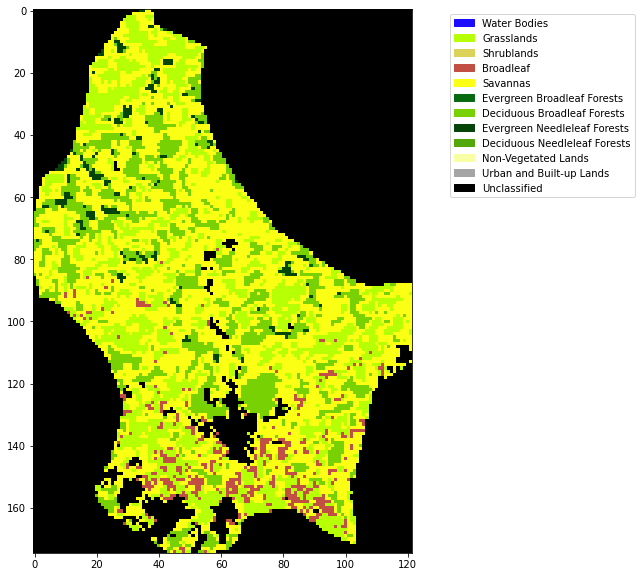

In [19]:
# plot
import matplotlib.pyplot as plt
x_size,y_size=(10,10)
fig, axs = plt.subplots(1,figsize=(x_size,y_size))
im = axs.imshow(land_cover,cmap=cmap,norm=norm,interpolation='nearest')
plt.legend(handles=patches,
          bbox_to_anchor=(1.6, 1),
          facecolor="white")

#### Exercise 3

* Write a function `get_lc` that takes as argument:
    
        year    : int
        tile    : list of MODIS tiles, list of st
        fips    : country FIPS code, str
        
  and returns a byte array of land cover type LC_Type3 for the year and country specified
* In your function, print out the unique values in the landcover dataset to give some feedback to the user
* Write a function `plot_LC_Type3` that will plot LC_Type3 data with an appropriate colourmap.
* Produce a plot of the land cover of Belgium for 2018

In [20]:
# ANSWER
from geog0111.modis import Modis
import gdal
import numpy as np

def get_lc(year,tile,fips):
    '''
    Return LC mask for year,tile,fips
    '''
    kwargs = {
        'tile'      :    tile,
        'product'   :    'MCD12Q1',
    }
    doy = 1
    # get the LC data
    modis = Modis(**kwargs)

    warp_args = {
      'dstNodata'     : 255,
      'format'        : 'MEM',
      'cropToCutline' : True,
      'cutlineWhere'  : f"FIPS='{fips}'",
      'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
    }

    # specify day of year (DOY) and year
    lcfiles = modis.get_modis(year,doy,warp_args=warp_args)
    # get the item we want
    g = gdal.Open(lcfiles['LC_Type3'])
    # error checking
    if not g:
        print(f"cannot open LC file {lcfiles['LC_Type3']}")
        return None
    lc = g.ReadAsArray()
    del g
    
    # in your function, print out the unique values in the 
    # landcover dataset to give some feedback to the user
    print(f"class codes: {np.unique(lc)}")
    return lc

In [21]:
# ANSWER
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches
import pandas as pd

def plot_LC_Type3(land_cover):
    # read the colour data
    lc_Type3 = pd.read_csv('data/LC_Type3_colour.csv')   
    # set up cmap and norm for colour scale
    cmap = matplotlib.colors.\
            ListedColormap(list(lc_Type3['colour']))
    norm = matplotlib.colors.\
            BoundaryNorm(list(lc_Type3['code']), len(lc_Type3['code']))

    # set up the legend
    legend_labels = dict(zip(list(lc_Type3['colour']),list(lc_Type3['class'])))
    patches = [matplotlib.patches.Patch(color=c, label=l)
               for c,l in legend_labels.items()]

    x_size,y_size=(10,10)
    fig, axs = plt.subplots(1,figsize=(x_size,y_size))
    im = axs.imshow(land_cover,cmap=cmap,norm=norm,interpolation='nearest')
    plt.legend(handles=patches,
              bbox_to_anchor=(1.4, 1),
              facecolor="white")

class codes: [  0   1   3   4   5   6   7   9  10 255]


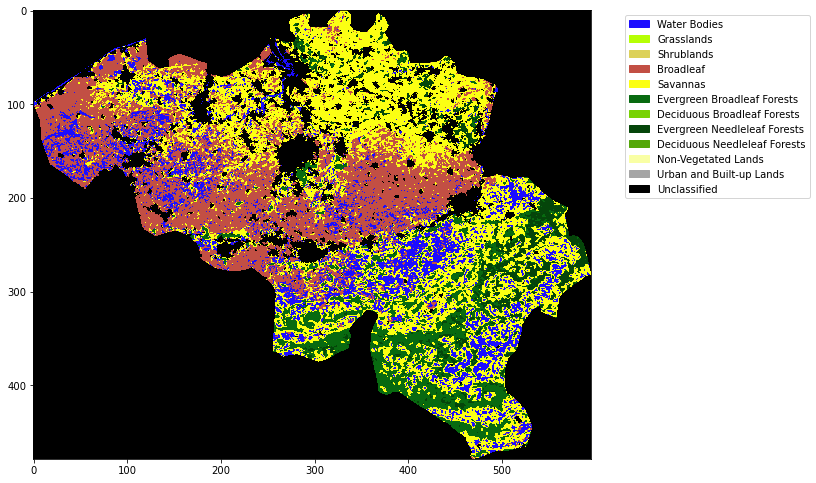

In [22]:
# Produce a plot of the land cover of Belgium for 2018
# ANSWER
year = 2018
fips = "BE"
tile = ['h17v03', 'h18v03','h17v04', 'h18v04']
lc = get_lc(year,tile,fips)
plot_LC_Type3(lc)

We can now consider masking both for valid pixels and for a particular land cover type.

In [23]:
# reload the dataset
from geog0111.get_lai_data import get_lai_data
from geog0111.get_weight import get_weight
from geog0111.regularise import regularise

year = 2019
tile = ['h17v03', 'h18v03','h17v04', 'h18v04']
fips = "LU"
lc = get_lc(year,tile,fips)
lc_Type3 = pd.read_csv('data/LC_Type3_colour.csv')
lai,std,doy =  get_lai_data(year,tile,fips)
weight = get_weight(lai,std)
interpolated_lai = regularise(lai,weight,5.0)

class codes: [  1   3   4   5   6   7  10 255]


In [24]:
# get the code for Grasslands
# might be easier to look in the table ...
# but we can extract it
classy = 'Grasslands'
code = int(lc_Type3[lc_Type3['class'] == classy]['code'])
print(f'code for {classy} is {code}')

code for Grasslands is 1


In [25]:
# code 
code_mask = (land_cover == code)
valid_mask = ~np.isnan(np.sum(interpolated_lai,axis=0))

# combine
mask = np.logical_and(code_mask,valid_mask)
masked_lai = interpolated_lai[:,mask]
print(masked_lai.shape)

(92, 2661)


Notice how we used `interpolated_lai[:,mask]` to apply the mask to the last 2 dimensions of the `interpolated_laia dataset. The result is 2D, the first dimension being the number of time samples.

Now, take the mean, over axis 1:

In [26]:
mean_lai = np.mean(masked_lai,axis=(1))
median_lai = np.median(masked_lai,axis=(1))
max_lai = np.max(masked_lai,axis=(1))
min_lai = np.min(masked_lai,axis=(1))

# check they have the same shape before we plot them!
masked_lai.shape,doy.shape

((92, 2661), (92,))

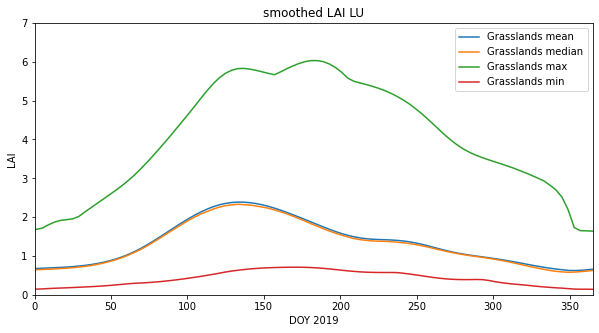

In [27]:
# plot 
x_size,y_size=(10,5)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,mean_lai,label=f"{classy} mean")
axs.plot(x,median_lai,label=f"{classy} median")
axs.plot(x,max_lai,label=f"{classy} max")
axs.plot(x,min_lai,label=f"{classy} min")
axs.set_title(f'smoothed LAI LU')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_ylabel('LAI')
axs.set_xlabel('DOY 2019')
axs.set_xlim(0,365)
axs.legend(loc='upper right')

## Formative assessment

To get some feedback on how you are doing, you should complete and submit the formative assessment [065 LAI](065_LAI.ipynb).

## Summary

From this session, you should be able to acquire a MODIS timeseries dataset and associated land cover map. You should be able to treat the data, so that by defining a weight for weach observation, you can produce a regularised (smoothed, interpolated) dataset from original noisy observations. In this case, we used variable weighting, according to an uncertainty measure, but if that is not available, you can simply use a weight of 1 for a valid observation and 0 when there is no valid value. 

You should then be able to calculate statistics from the data. You should be capable of doing this for any MODIS geophysical variable, and also of developing functiuons that bring some of these ideas together into more compact, reusable code.


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](050_Models.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](042_Weighted_smoothing_and_interpolation.ipynb)


